In [1]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
import seaborn as sns

In [2]:
import torch
import os
import numpy as np
import random

# 1. Reproducibility Setup 
# Setting seeds for all relevant libraries to ensure consistent results
seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    # Only set CUDA seed if a GPU is available
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True # Uncomment for maximum determinism (might impact performance)
    # torch.backends.cudnn.benchmark = False    # Uncomment for maximum determinism
np.random.seed(seed)
random.seed(seed)

# 2. Hardware and Paths 

# Device selection: use CUDA (GPU) if available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device set to: {device}")

# Directory paths (Updated for Cucumber Disease Recognition Project)
# NOTE: You may need to adjust the specific folder name based on your mounted dataset.
data_dir = "/kaggle/input/original-image-of-cucumber-disease-recognition/Original Image"
output_dir = "/kaggle/working/processed-dataset"
checkpoints_path = "/kaggle/working/"

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(checkpoints_path, exist_ok=True)

# 3. Hyperparameters and Training Configuration 

# Batch sizes
train_batch = 32
test_batch = 16

# Model/Training parameters
# Updated total_class from 3 to 8, a common count for cucumber disease datasets
total_class = 8         # Number of classes (e.g., Healthy, Anthracnose, Downy Mildew, etc.)
learning_rate = 0.0001  # Initial learning rate
decay = 1e-4            # Weight decay (L2 regularization)
epoch = 100             # Total number of epochs to train
patience = 100          # Patience for early stopping (e.g., how many epochs to wait for improvement)

print("\nConfiguration Summary:")
print(f"Project Focus: Cucumber Disease Recognition")
print(f"Data Source: {data_dir}")
print(f"Output Directory: {output_dir}")
print(f"Total Classes: {total_class}")
print(f"Learning Rate: {learning_rate}")
print(f"Total Epochs: {epoch}")

Device set to: cpu

Configuration Summary:
Project Focus: Cucumber Disease Recognition
Data Source: /kaggle/input/original-image-of-cucumber-disease-recognition/Original Image
Output Directory: /kaggle/working/processed-dataset
Total Classes: 8
Learning Rate: 0.0001
Total Epochs: 100


Scanning directory: /kaggle/input/original-image-of-cucumber-disease-recognition/Original Image
Total images found: 1289
Initial split sizes (before preprocessing cleanup): Train=902, Val=193, Test=194

--- 5. Preprocessing and Resizing Images to 224x224 ---


Processing test: 100%|██████████| 194/194 [00:22<00:00,  8.78it/s]


Final split sizes (after preprocessing cleanup): Train=902, Val=193, Test=194

Dataset Split Ratios (Post-Processing)
Train: 902 images (69.98%)
Test: 194 images (15.05%)
Validation: 193 images (14.97%)


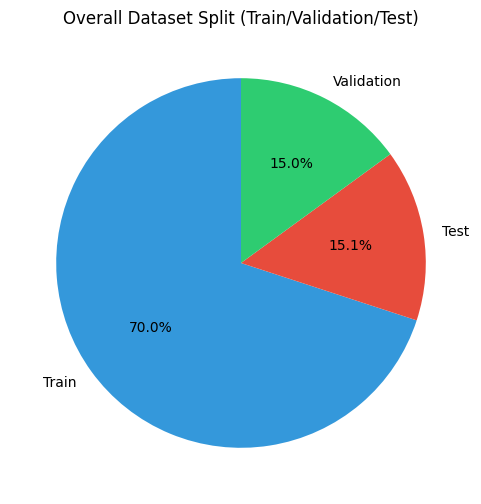

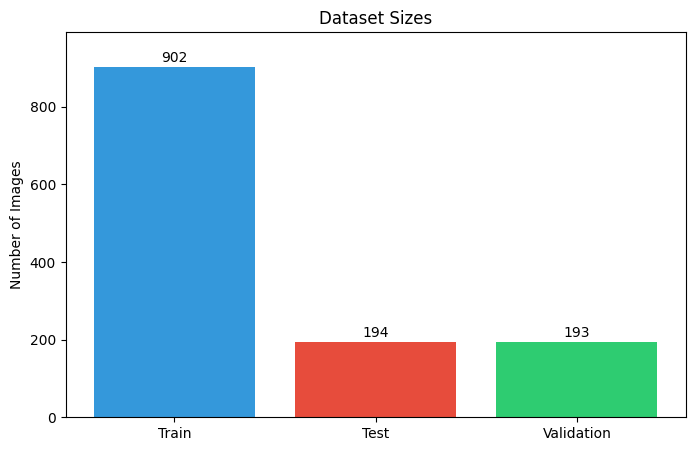

/tmp/ipykernel_48/3764482837.py:188: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(all_labels))
/tmp/ipykernel_48/3764482837.py:206: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_counts.index, rotation=45, ha='right')
/tmp/ipykernel_48/3764482837.py:206: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_counts.index, rotation=45, ha='right')
/tmp/ipykernel_48/3764482837.py:206: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_counts.index, rotation=45, ha='right')


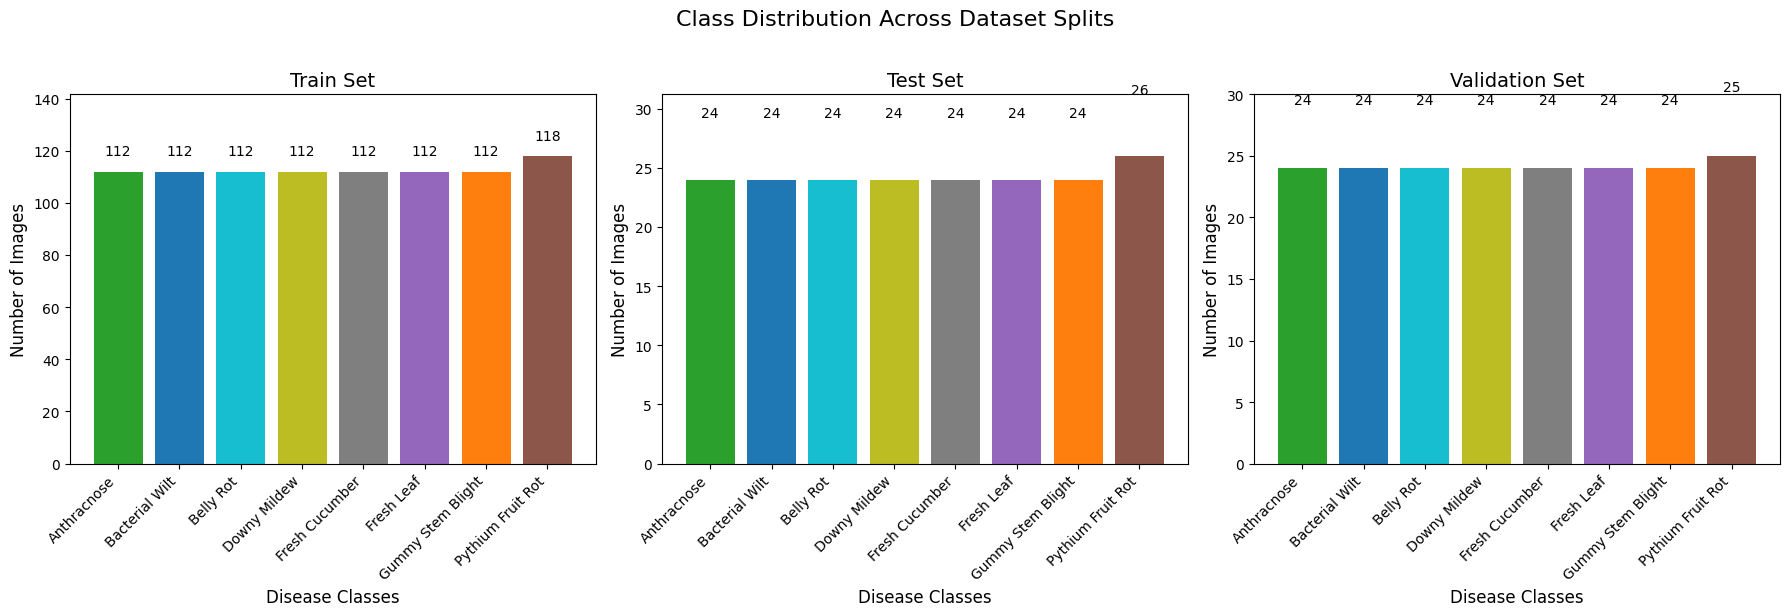


Visualizing a random sample from the Training Set (Post-Preprocessing)...


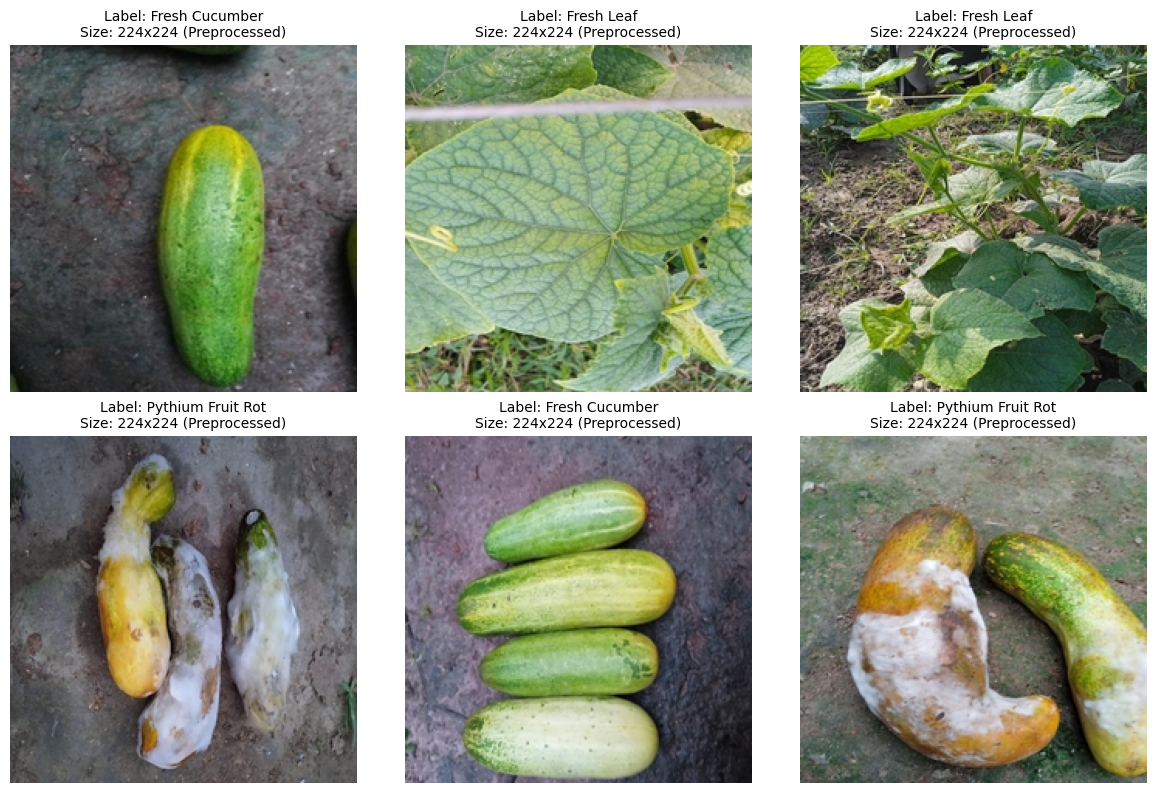


Checking the number of color channels in a sample processed image...
Sample Processed Image Path: /kaggle/working/processed-dataset/train/Bacterial Wilt/Bacterial Wilt (98).jpg
Number of channels: 3 (RGB (Red, Green, Blue))


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random 
from PIL import Image 
from tqdm import tqdm # Added for progress bars

#  1. Configuration (Data path and seed)
data_dir = "/kaggle/input/original-image-of-cucumber-disease-recognition/Original Image"
output_dir = "/kaggle/working/processed-dataset" # Path retrieved from config_setup.py
seed = 42 
size = (224, 224) # Target size for image resizing

# Ensure the output base directory exists
os.makedirs(output_dir, exist_ok=True)

#  2. Data Loading Function
def load_split(root_dir):
    """
    Loads file paths and labels from subdirectories within the root directory.
    Assumes each subdirectory is a class label.
    """
    file_paths, labels = [], []
    print(f"Scanning directory: {root_dir}")

    try:
        for entry in os.scandir(root_dir):
            if entry.is_dir():
                class_name = entry.name
                class_dir = entry.path

                # Skip hidden/system folders
                if class_name.startswith('.'):
                    continue

                for image_entry in os.scandir(class_dir):
                    if image_entry.is_file():
                        file_paths.append(image_entry.path)
                        labels.append(class_name)
    except FileNotFoundError:
        print(f"Error: Directory not found at {root_dir}. Please check your 'data_dir' path.")
        return pd.DataFrame({"file_path": [], "label": []})

    return pd.DataFrame({"file_path": file_paths, "label": labels})

# 3. Data Preprocessing Function 
def data_preprocess(df, split_name, size=size, quality=100):
    """
    Resizes and converts images to RGB, then saves them to a structured output directory.
    Updates the DataFrame with the new file paths.
    """
    split_dir = os.path.join(output_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)

    processed_file_paths = []

    # Use tqdm to show processing progress
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        label = row['label']
        label_dir = os.path.join(split_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        try:
            # Open, convert to RGB (ensures 3 channels), and resize
            img = Image.open(row['file_path']).convert("RGB")  
            # Use LANCZOS for high-quality downsampling/resizing
            img = img.resize(size, Image.Resampling.LANCZOS)

            file_name = os.path.basename(row['file_path'])
            save_path = os.path.join(label_dir, file_name)
            
            # Save the image (optimize=True and high quality for better compression)
            img.save(save_path, optimize=True, quality=quality)

            processed_file_paths.append(save_path)
        except Exception as e:
            # Fallback in case an image is corrupted or cannot be processed
            print(f"\n[WARNING] Error processing file {row['file_path']}: {e}. Skipping image.")
            # Use numpy's nan or a specific placeholder if the image should be dropped later
            processed_file_paths.append(np.nan) 

    # Clean up any rows where image processing failed
    df['file_path'] = processed_file_paths
    df.dropna(subset=['file_path'], inplace=True)
    
    # Reset index after dropping rows
    df.reset_index(drop=True, inplace=True) 
    
    return df

#  4. Data Loading and Splitting 

data = load_split(data_dir)

if data.empty:
    print("No images were loaded. Cannot perform split analysis.")
else:
    print(f"Total images found: {len(data)}")

    # Split data into training (70%) and a temporary set (30%)
    train_dataframe, temp_dataframe = train_test_split(
        data, 
        test_size=0.30, 
        stratify=data['label'], 
        random_state=seed)

    # Split temporary set into validation (15%) and test (15%)
    validation_dataframe, test_dataframe = train_test_split(
        temp_dataframe, 
        test_size=0.50, # 50% of the 30% temp_dataframe = 15% of total
        stratify=temp_dataframe['label'], 
        random_state=seed)

    print(f"Initial split sizes (before preprocessing cleanup): Train={len(train_dataframe)}, Val={len(validation_dataframe)}, Test={len(test_dataframe)}")

    # --- 5. Data Preprocessing Execution ---
    print("\n--- 5. Preprocessing and Resizing Images to 224x224 ---")
    
    # Only process if dataframes are not empty
    if not train_dataframe.empty:
        train_dataframe = data_preprocess(train_dataframe, "train")
    if not validation_dataframe.empty:
        validation_dataframe = data_preprocess(validation_dataframe, "val")
    if not test_dataframe.empty:
        test_dataframe = data_preprocess(test_dataframe, "test")

    print(f"Final split sizes (after preprocessing cleanup): Train={len(train_dataframe)}, Val={len(validation_dataframe)}, Test={len(test_dataframe)}")


    #  6. Analysis and Visualization (Overall Split) 

    sizes = {
        "Train": len(train_dataframe),
        "Test": len(test_dataframe),
        "Validation": len(validation_dataframe)}

    total = sum(sizes.values())
    ratios = {k: (v / total) * 100 for k, v in sizes.items()}

    print("\nDataset Split Ratios (Post-Processing)")
    for split in sizes.keys():
        print(f"{split}: {sizes[split]} images ({ratios[split]:.2f}%)")

    # Pie Chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        sizes.values(),
        labels=sizes.keys(),
        autopct="%.1f%%",
        startangle=90,
        colors=["#3498db", "#e74c3c", "#2ecc71"]) 
    plt.title("Overall Dataset Split (Train/Validation/Test)")
    plt.show()

    # Bar Chart (Overall)
    plt.figure(figsize=(8, 5))
    bar_colors = ["#3498db", "#e74c3c", "#2ecc71"]
    bars = plt.bar(sizes.keys(), sizes.values(), color=bar_colors)
    plt.ylabel("Number of Images")
    plt.title("Dataset Sizes")
    
    # Add labels on top of the bars
    y_max = max(sizes.values()) * 1.1 
    plt.ylim(0, y_max)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + total*0.005, f'{height}', ha='center', va='bottom')
    
    plt.show()
    
    #  7. Class Distribution Visualization 

    def class_distribution(train_df, test_df, val_df):
        """
        Plots the distribution of classes across the Train, Test, and Validation splits.
        """
        datasets = {
            "Train": train_df,
            "Test": test_df,
            "Validation": val_df
        }
        
        # Determine unique classes across all datasets for consistent color mapping
        all_labels = pd.concat([df['label'] for df in datasets.values()]).unique()
        # Use a qualitative colormap for distinct classes
        colors = plt.cm.get_cmap('tab10', len(all_labels))
        color_map = {label: colors(i) for i, label in enumerate(all_labels)}
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle("Class Distribution Across Dataset Splits", fontsize=16, y=1.02)
        
        for ax, (split_name, df) in zip(axes, datasets.items()):
            class_counts = df['label'].value_counts().sort_index()

            # Map class colors
            bar_colors = [color_map[label] for label in class_counts.index]

            bars = ax.bar(class_counts.index, class_counts.values, color=bar_colors)
            ax.set_xlabel('Disease Classes', fontsize=12)
            ax.set_ylabel('Number of Images', fontsize=12)
            ax.set_title(f'{split_name} Set', fontsize=14)
            
            # Rotate labels for better fit (45 degrees is better than 360/0)
            ax.set_xticklabels(class_counts.index, rotation=45, ha='right') 
            
            # Add counts on top of the bars
            y_max = max(class_counts) * 1.2 if not class_counts.empty else 100
            ax.set_ylim(0, y_max)
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, height + 5, str(height), ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()

    # Call the class distribution function
    class_distribution(train_dataframe, test_dataframe, validation_dataframe)

    #  8. Visualize Random Sample of Training Images 

    print("\nVisualizing a random sample from the Training Set (Post-Preprocessing)...")
    
    # Create 2 rows and 3 columns of plots
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten() # Flattens the 2D array of axes into a 1D array for easy iteration

    for ax in axes:
        # Select a random index and the corresponding row from the training DataFrame
        random_index = random.randint(0, len(train_dataframe) - 1)
        random_row = train_dataframe.iloc[random_index]

        file_path = random_row['file_path']
        label = random_row['label']

        try:
            # Image is loaded from the new processed path
            image = Image.open(file_path) 
            width, height = image.size

            ax.imshow(image)
            # The title confirms the new size
            ax.set_title(f"Label: {label}\nSize: {width}x{height} (Preprocessed)", fontsize=10) 
            ax.axis('off') # Hide axes ticks and labels

        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading image: {e}", ha='center', va='center', fontsize=8, color='red')
            ax.set_title("Image Load Failed", fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    #  9. Check Image Channel Count (on processed image) 

    print("\nChecking the number of color channels in a sample processed image...")
    
    if not train_dataframe.empty:
        # Select the first image in the processed training set for the check
        sample_image_path = train_dataframe['file_path'].iloc[0]
        try:
            img = Image.open(sample_image_path)
            num_channels = len(img.getbands())
            
            channel_info = {
                1: "Grayscale", 
                3: "RGB (Red, Green, Blue)", 
                4: "RGBA (RGB with Alpha/Transparency)"
            }.get(num_channels, f"{num_channels} (Uncommon format)")
            
            print(f"Sample Processed Image Path: {sample_image_path}")
            print(f"Number of channels: {num_channels} ({channel_info})")
            
        except Exception as e:
            print(f"Error reading sample image at {sample_image_path}: {e}")
    else:
        print("Cannot check channel count, training dataframe is empty.")

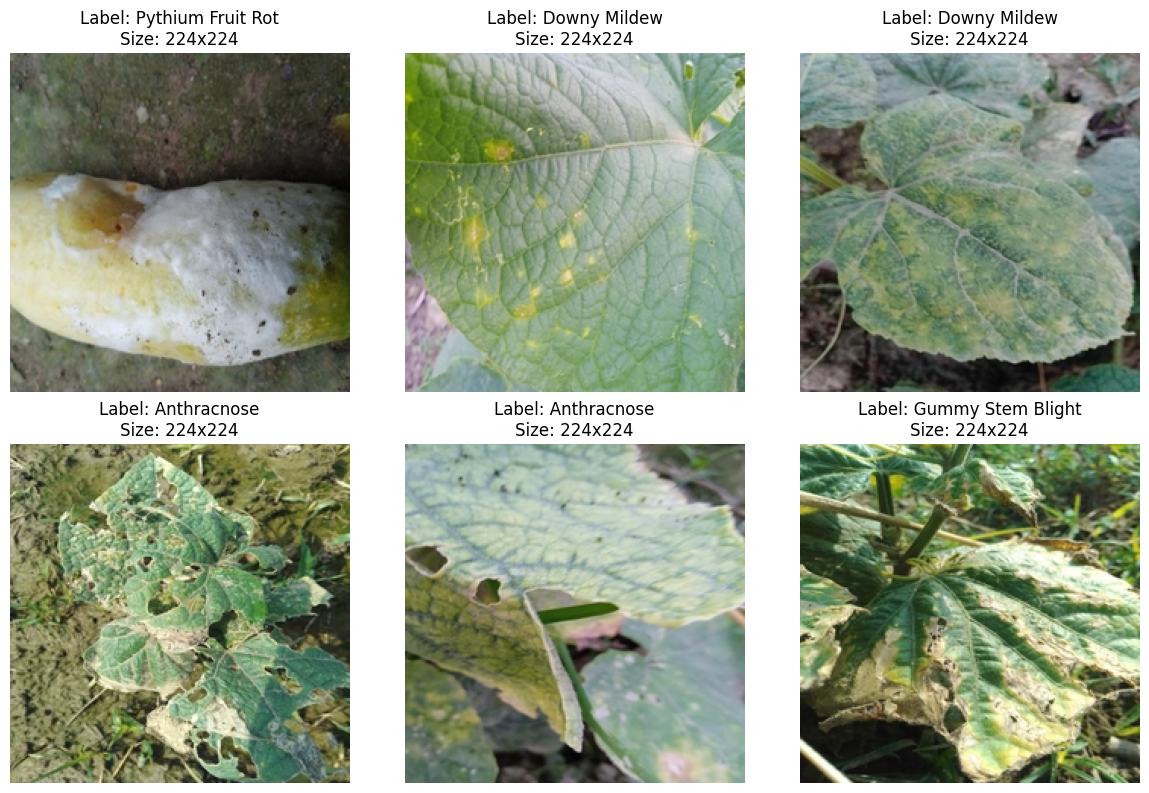

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for ax in axes:
    # Ensure the dataframe is not empty before sampling
    if not train_dataframe.empty:
        random_index = random.randint(0, len(train_dataframe) - 1)
        random_row = train_dataframe.iloc[random_index]

        file_path = random_row['file_path']
        label = random_row['label']

        try:
            image = Image.open(file_path)
            width, height = image.size

            ax.imshow(image)
            # Added a newline to the title for better readability
            ax.set_title(f"Label: {label}\nSize: {width}x{height}")
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f"Load Error: {e}", ha='center', va='center')
            ax.set_title("Image Load Failed")
            ax.axis('off')
    else:
        ax.set_title("DataFrame is Empty")
        ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image as PIL_Image # Use alias for clarity

#  Configuration Reference (Assumed to be available from config_setup.py) 
# NOTE: These variables are assumed to be defined by your environment based on the configuration.
train_batch = 32
test_batch = 16
# Assuming train_dataframe, validation_dataframe, test_dataframe are available.

class ImageDataset(Dataset):
    """
    Custom PyTorch Dataset for loading images from a pandas DataFrame 
    and applying transformations.
    """
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        
        # Handle empty DataFrame gracefully
        if self.dataframe.empty:
            self.label_map = {}
            self.class_names = []
            return

        # Create a consistent label mapping for integer encoding
        unique_labels = sorted(self.dataframe['label'].unique())
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}
        self.class_names = unique_labels

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        
        # Open, convert to RGB, and apply transformation
        image = PIL_Image.open(img_path).convert("RGB")
        
        if self.is_lb:
            # Supervised learning: return image and encoded label
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            # Unsupervised learning (or self-supervised): return image twice
            return self.normalize(image), self.normalize(image)

def data_transfrom():
    """
    Defines transformations, creates ImageDatasets, and instantiates DataLoaders.
    """
    # Standard transformation (used for validation and testing)
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Standard ImageNet normalization statistics
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Training transformation (includes strong augmentations)
    train_transform = transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=3),
        transforms.ToTensor(),
        # Standard ImageNet normalization statistics
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # 1. Create Datasets (is_lb=True for supervised classification)
    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        validation_dataframe,
        transform,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_dataframe,
        transform,
        is_lb=True
    )

    # 2. Print Label Encoding Map (using the training dataset's map)
    print("Label encoding:")
    if train_dataset.label_map:
        for label, idx in train_dataset.label_map.items():
            print(f"{label} -> {idx}")
    else:
        print("Warning: No classes to map as the training dataframe is empty.")
        
    # 3. Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    validation_dataloader = DataLoader(valid_dataset, batch_size = test_batch, shuffle=False, num_workers=2)
    test_dataloader = DataLoader(test_dataset, batch_size = test_batch, shuffle=False, num_workers=2)

    return train_dataloader, validation_dataloader, test_dataloader

# Execute the data preparation pipeline
train_dataloader, validation_dataloader, test_dataloader = data_transfrom()

Label encoding:
Anthracnose -> 0
Bacterial Wilt -> 1
Belly Rot -> 2
Downy Mildew -> 3
Fresh Cucumber -> 4
Fresh Leaf -> 5
Gummy Stem Blight -> 6
Pythium Fruit Rot -> 7


Restnet50 Model Training

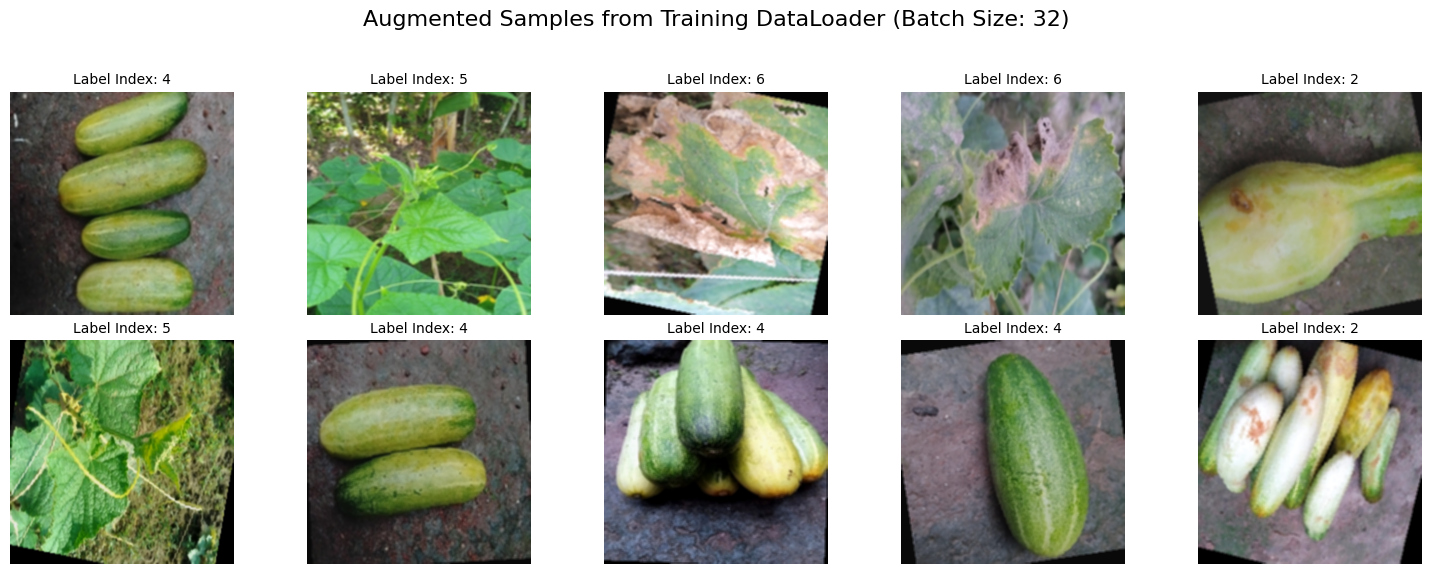

In [7]:
import torch
import matplotlib.pyplot as plt

def augmented_samples(dataloader, num_images=10):
    """
    Retrieves a batch from the DataLoader, denormalizes the images,
    and visualizes the first 'num_images' augmented samples.

    Args:
        dataloader (torch.utils.data.DataLoader): The DataLoader to sample from (e.g., train_dataloader).
        num_images (int): The number of images to display.
    """
    # Get one batch of images and labels
    try:
        images, labels = next(iter(dataloader))
    except StopIteration:
        print("Error: DataLoader is empty.")
        return
    except NameError:
        print("Error: 'dataloader' variable (e.g., train_dataloader) is not defined. Ensure data_loader_setup.py ran first.")
        return

    # ImageNet Mean and Standard Deviation (used for denormalization)
    mean = torch.tensor([0.485, 0.456, 0.406], device=images.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=images.device)
    
    # Denormalize the images: (image * std) + mean
    # The [None, :, None, None] broadcasts the 1D mean/std tensors to 
    # match the batch tensor shape (Batch, Channel, Height, Width)
    images = images * std[None, :, None, None] + mean[None, :, None, None]
    
    # Clamp pixel values to the valid range [0, 1] after denormalization
    images = torch.clamp(images, 0, 1)  

    # Setup the plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Augmented Samples from Training DataLoader (Batch Size: {images.shape[0]})", fontsize=16)

    # Display images
    for i, ax in enumerate(axes.flat):
        if i >= num_images or i >= images.shape[0]:
            ax.axis("off")
            continue
            
        # Move channel dimension to the last position for Matplotlib (H, W, C)
        img = images[i].permute(1, 2, 0).cpu().numpy() 
        label_idx = labels[i].item()
        
        # NOTE: To show the actual disease name instead of index, you would need
        # the class_names list from the ImageDataset, but we use the index here.
        ax.imshow(img)
        ax.set_title(f"Label Index: {label_idx}", fontsize=10)
        ax.axis("off")
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()

# Execution call (assumes train_dataloader is available)
augmented_samples(train_dataloader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import models
from tqdm import tqdm
import time
import pandas as pd
import os


try:
    device
    total_class
    learning_rate
    decay
    epoch
    patience
    checkpoints_path
    train_dataloader
    validation_dataloader
except NameError:
    print("Warning: Configuration variables or DataLoaders not found. Using fallbacks.")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    learning_rate = 1e-5     
    decay = 5e-4             
    total_class = 8          
    epoch = 50               
    patience = 10            
    checkpoints_path = "/kaggle/working/checkpoints"
    # IMPORTANT: These must be properly initialized DataLoaders in a real environment
    train_dataloader = None  
    validation_dataloader = None 
    os.makedirs(checkpoints_path, exist_ok=True)
    print(f"Using device: {device}")
    


class ResNet50Classifier(nn.Module):
    """
    Custom ResNet-50 model implementing Deeper Fine-Tuning.
    Freezes most layers but UNFREEZES layer4, layer3, and the new classification head.
    """
    def __init__(self, num_classes, fine_tune_layers=True):
        super(ResNet50Classifier, self).__init__()
        
        print("Attempting to load pre-trained ResNet50 weights...")
        try:
            # Load ResNet50 with best available ImageNet weights
            self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            print("Successfully loaded ImageNet weights.")
        except Exception as e:
            print(f"Warning: Failed to load ImageNet weights. Initializing model with random weights. Error: {e}")
            self.model = models.resnet50(weights=None)

        # --- CRITICAL: Implement Deeper Fine-Tuning (Layer3 and Layer4) ---
        if fine_tune_layers:
            # 1. Freeze ALL existing parameters first
            for param in self.model.parameters():
                param.requires_grad = False
            
            # 2. Unfreeze the last two convolutional blocks (layer4 and layer3)
            # Unfreeze Layer 4 (last feature block)
            for param in self.model.layer4.parameters():
                param.requires_grad = True
            
            # UNFREEZE Layer 3 (second-to-last feature block)
            for param in self.model.layer3.parameters():
                param.requires_grad = True
            
            print("Feature extraction layers: layer4 and layer3 are UNROZEN for deeper fine-tuning.")
        else:
            # Standard feature extraction (only FC head is trainable)
            for param in self.model.parameters():
                param.requires_grad = False
            print("Feature extraction layers (convolutional base) are frozen.")

        # 3. Modify the final classification layer (This is always trainable)
        num_ftrs = self.model.fc.in_features
        
        # Define a new, robust classification head with ReLU and Dropout
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Regularization
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)



model = ResNet50Classifier(num_classes=total_class, fine_tune_layers=True)
model.to(device)
print(f"Model: ResNet50 (Deeper Fine-Tuned) initialized for {total_class} classes.")

# Loss Function: Cross-Entropy is correct for multi-class classification
criterion = nn.CrossEntropyLoss()


fine_tune_lr_layer4 = learning_rate / 10   # 10x smaller for layer4
fine_tune_lr_layer3 = learning_rate / 100  # 100x smaller for layer3

# CRITICAL: Define parameters with three distinct LRs
optimizer = optim.AdamW([
    # 1. Classifier Head (new layers) - use full LR (e.g., 1e-5)
    {'params': model.model.fc.parameters(), 'lr': learning_rate},  
    
    # 2. Layer 4 (fine-tuned, shallower feature extractor) - use reduced LR (e.g., 1e-6)
    {'params': model.model.layer4.parameters(), 'lr': fine_tune_lr_layer4},
    
    # 3. Layer 3 (fine-tuned, deeper feature extractor) - use lowest LR (e.g., 1e-7)
    {'params': model.model.layer3.parameters(), 'lr': fine_tune_lr_layer3}
], lr=learning_rate, weight_decay=decay) # The default 'lr' is overridden by the dicts


scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

print(f"Optimizer: AdamW (Head LR: {learning_rate}, Layer4 LR: {fine_tune_lr_layer4}, Layer3 LR: {fine_tune_lr_layer3}, Decay: {decay}), Scheduler: ReduceLROnPlateau.")

# --- 4. TRAINING FUNCTION (No change needed here) ---

def train_model(model, criterion, optimizer, scheduler, train_dataloader, validation_dataloader, num_epochs=epoch, early_stop_patience=patience, checkpoints_path=checkpoints_path):
    if train_dataloader is None or validation_dataloader is None:
        # Check if DataLoaders are placeholders and return empty lists to allow execution to continue without error
        print("ERROR: DataLoaders are not initialized. Cannot start training.")
        return [], [], [], [] # Return empty lists on error

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    best_epoch = 0

    print(f"\n--- Starting Fine-Tuning Training for {num_epochs} Epochs ---")

    for epoch_i in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training Loop
        # Note: If this is run in a Jupyter/Kaggle notebook, replace `tqdm` with a notebook-compatible progress bar like `tqdm.notebook.tqdm`
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), 
                            desc=f"Epoch {epoch_i+1}/{num_epochs} [TRAIN]")
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train, refresh=True)
            
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print(f'\nEpoch {epoch_i+1} - Training Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')

        # Validation Loop
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            progress_bar_val = tqdm(validation_dataloader, total=len(validation_dataloader), 
                                    desc=f"Epoch {epoch_i+1}/{num_epochs} [VALIDATE]")
            for inputs, labels in progress_bar_val:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f'Epoch {epoch_i+1} - Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
        
        # Step the scheduler based on validation accuracy (mode='max')
        scheduler.step(epoch_val_acc)

        # Checkpoint and Early Stopping Logic
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch_i + 1
            
            os.makedirs(checkpoints_path, exist_ok=True)
            filepath = os.path.join(checkpoints_path, "resnet50_best_model.pt")  
            
            checkpoint = {
                "epoch": epoch_i + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"--> CHECKPOINT: Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.4f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1
            print(f"EARLY STOP ACC COUNTER {consecutive_no_improvement}/{early_stop_patience}")

        # Stopping condition based on no validation accuracy improvement
        if consecutive_no_improvement >= early_stop_patience:
            print(f"Early stopping criteria met (no accuracy improvement). Training stopped at epoch {epoch_i+1}.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


start_time = time.time()

# CRITICAL FIX: Capture the returned history lists
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, 
    criterion, 
    optimizer, 
    scheduler, # Pass the scheduler
    train_dataloader, 
    validation_dataloader, 
    checkpoints_path=checkpoints_path
)

end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining Complete.")
print(f"Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


if len(train_loss_history) > 0:
    data = {
        'Epoch': list(range(1, len(train_loss_history) + 1)),
        'Train Loss': train_loss_history,
        'Train Accuracy': train_acc_history,
        'Validation Loss': val_loss_history,
        'Validation Accuracy': val_acc_history
    }
    history = pd.DataFrame(data)

    history_filepath = os.path.join(checkpoints_path, 'resnet50_training_logs.xlsx')
    history.to_excel(history_filepath, index=False)
    print(f"Training history saved to {history_filepath}")
else:
    print("No training history to save (DataLoaders were not available or training stopped immediately).")